In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time

from tqdm import tqdm

In [2]:
from fastkan import FastKAN as KAN
import matplotlib.pyplot as plt

In [17]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class KANNet(nn.Module):
    def __init__(self):
        super(KANNet, self).__init__()
        self.flatten = nn.Flatten()
        self.KAN = KAN([28 * 28, 7, 10])
        #self.KAN = KAN([28 * 28, 64, 10])

    def forward(self, x):
        x = self.flatten(x)
        x = self.KAN(x)
        return x

In [18]:
from torchinfo import summary
device = torch.device("cpu")

model = MLPNet().to(device)
print(summary(model, input_size=(1, 1, 28, 28)))

model = KANNet().to(device)
print(summary(model, input_size=(1, 1, 28, 28)))


Layer (type:depth-idx)                   Output Shape              Param #
MLPNet                                   [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 64]                   50,240
├─ReLU: 1-3                              [1, 64]                   --
├─Linear: 1-4                            [1, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
Layer (type:depth-idx)                        Output Shape              Param #
KANNet                                        [1, 10]                   --
├─Flatten: 1-1                                [1, 784]                  --
├─FastKAN: 1-2                                [1, 10]                   --
│    └─ModuleList: 2-1                        --      

In [19]:
# Task C: Record forward and backpropagation execution times
def time_forward_backward(model, data, target, criterion, optimizer):
    # Forward pass
    start_time = time.time()
    output = model(data)
    forward_time = time.time() - start_time

    # Backward pass
    start_time = time.time()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    backward_time = time.time() - start_time

    return forward_time, backward_time

In [20]:
def main():
    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Create model, loss function, and optimizer
    model = KANNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Training loop
    num_epochs = 5
    avg_forward_times = []
    avg_backward_times = []

    for epoch in range(num_epochs):
        total_forward_time = 0
        total_backward_time = 0
        num_batches = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            forward_time, backward_time = time_forward_backward(model, data, target, criterion, optimizer)
            
            total_forward_time += forward_time
            total_backward_time += backward_time
            num_batches += 1

            # if batch_idx % 100 == 0:
                # print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}:")
                # print(f"  Forward pass time: {forward_time:.6f} seconds")
                # print(f"  Backward pass time: {backward_time:.6f} seconds")
                # print(f"  Total time: {forward_time + backward_time:.6f} seconds")

        avg_forward_time = total_forward_time / num_batches
        avg_backward_time = total_backward_time / num_batches
        avg_forward_times.append(avg_forward_time)
        avg_backward_times.append(avg_backward_time)

        # print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        # print(f"  Avg Forward pass time: {avg_forward_time:.6f} seconds")
        # print(f"  Avg Backward pass time: {avg_backward_time:.6f} seconds")
        # print(f"  Avg Total time: {avg_forward_time + avg_backward_time:.6f} seconds")

    # Plotting the results
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, avg_forward_times, label='Avg Forward Time')
    plt.plot(epochs, avg_backward_times, label='Avg Backward Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Average Forward and Backward Pass Times')
    plt.legend()
    plt.show()


100%|██████████| 938/938 [00:16<00:00, 58.17it/s]


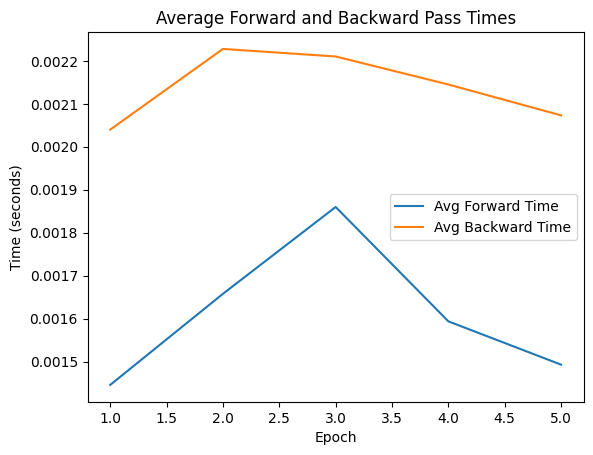

In [21]:
if __name__ == "__main__":
    main()

In [10]:
print('Average Forward Times')
print(avg_forward_times)
print('Average Backward Times')
print(avg_backward_times)

Average Forward Times


NameError: name 'avg_forward_times' is not defined